In [483]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from datetime import datetime, timedelta

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn import metrics

import statsmodels.formula.api as sm

from IPython.display import Image

In [286]:
df = pd.read_csv('data.csv', index_col = 'id')

In [344]:
df.shape

(6602, 129)

In [287]:
df.head()

,start,end,record,prog,duration,18?,US?,sex,age,trip_int,...,impact_5,impact_6,race,state,urban,work,healthcare,child,educ,polit
id,,,,,,,,,,,,,,,,,,,,,
ID0001,3/20/20 17:04,3/20/20 17:13,3/20/20 17:13,100,535,Yes,Yes,Male,18-29 years old,0,...,More than half the days,Nearly every day,"White, Non-Hispanic",Illinois,Urban,"Unpaid work (e.g., homemaker, eldercare, child...",No,Yes,High School diploma or GED,Republican
ID0002,3/20/20 17:07,3/20/20 17:20,3/20/20 17:20,100,771,Yes,Yes,Female,40-49 years old,0,...,Nearly every day,Nearly every day,"White, Non-Hispanic",Ohio,Suburban,Employed,No,Yes,Bachelor‚Äôs degree,Prefer not to say
ID0003,3/20/20 17:09,3/20/20 17:20,3/20/20 17:20,100,668,Yes,Yes,Female,30-39 years old,0,...,More than half the days,Several days,"White, Non-Hispanic",Minnesota,Suburban,"Unpaid work (e.g., homemaker, eldercare, child...",No,Yes,Masters/Professional degree or above,Prefer not to say
ID0004,3/20/20 17:04,3/20/20 17:23,3/20/20 17:23,100,1130,Yes,Yes,Female,50-59 years old,0,...,Not at all,Not at all,"Black, Non-Hispanic",Mississippi,Rural,Employed,No,Yes,Bachelor‚Äôs degree,Prefer not to say
ID0005,3/20/20 17:36,3/20/20 17:46,3/20/20 17:46,100,567,Yes,Yes,Female,60-69 years old,0,...,Several days,Not at all,"White, Non-Hispanic",Connecticut,Suburban,Retired,No,No,Bachelor‚Äôs degree,Democrat


# 1. Data Preprocessing (Feature Engineering)

In [288]:
# survey duration을 뽑고, 서베이 종료 시간이랑 기록 시간은 삭제함
df['start'] = df['start'].apply(lambda x: datetime.strptime(x, '%m/%d/20 %H:%M'))
df['end'] = df['end'].apply(lambda x: datetime.strptime(x, '%m/%d/20 %H:%M'))
# df['survey_duration'] = (df['end'] - df['start']).apply(lambda x: x.total_seconds()) # 이미 duration 있었음!
df = df.drop(['end', 'record'], axis = 1)

In [289]:
# survey 작성 시작 시점을 survey 게시일로부터 흐른 hours로 계산
df['start'] = (df['start'] - datetime(year=1900, month=3, day=20)) // timedelta(hours = 1)

In [290]:
possibly_ordinal = ['trip_risk', 'trav_sev', 'trav_cruise', 'trav_plan_int', 'trav_plan_dom', 'belief_1', \
                    'belief_2', 'belief_3', 'belief_4', 'belief_5', 'belief_6', 'belief_7', 'belief_8', 'belief_9', 'belief_10', \
                    'belief_11', 'belief_12', 'threat_secur', 'threat_econ', 'threat_pers', 'attid_pol_1', 'attid_pol_2', \
                    'attid_pol_3', 'attid_pol_4', 'attid_pol_5', 'attid_pol_6', 'attid_pol_7', 'optimism ', 'anx_1', 'anx_2', \
                    'anx_3', 'anx_4', 'impact_1', 'impact_2', 'impact_3', 'impact_4', 'impact_5', 'impact_6']
possible_y = ['trip_risk', 'know', 'alerted', 'search', 'behav', 'percv_risk', 'mon_cases', 'percv_sev', 'anx', 'impact']

In [291]:
# 지식 점수
df['know'] = 0
for i, answer in zip(range(1, 14), [True, False, True, True, True, True, False, True, True, False, False, False, True]):
    df['know'] += (df['know_' + str(i)] == answer).fillna(False).apply(int)

In [292]:
# 경각심 지수
df['alerted'] = 0
for i in range(1, 11):
    df['alerted'] += df['knowinf_' + str(i)].fillna(False).apply(int)

In [293]:
# 행동 지수 - 사실 경각심 지수랑 큰 차이는 모르겠긴 함.
df['behav'] = 0
for i in range(1, 13):
    df['behav'] += df['behav_' + str(i)].fillna(False).apply(int)

In [294]:
# 불안 지수
score_map = {'Not at all': 0, 'Several days': 1, 'More than half the days': 2, 'Nearly every day': 3}
df['anx'] = 0
for i in range(1, 5):
    df['anx'] += df['anx_'+str(i)].fillna('Not at all').apply(lambda x: score_map[x])

In [295]:
# 영향 지수
df['impact'] = 0
for i in range(1, 7):
    df['impact'] += df['impact_'+str(i)].fillna('Not at all').apply(lambda x: score_map[x])

In [296]:
# 18세 이상 여부, US citizen 여부는 1/0으로 라벨링 (기존 Yes/No로 라벨링되어 있었음)
df['18?'] = df['18?'].apply(lambda x: int(x == 'Yes'))
df['US?'] = df['US?'].apply(lambda x: int(x == 'Yes'))

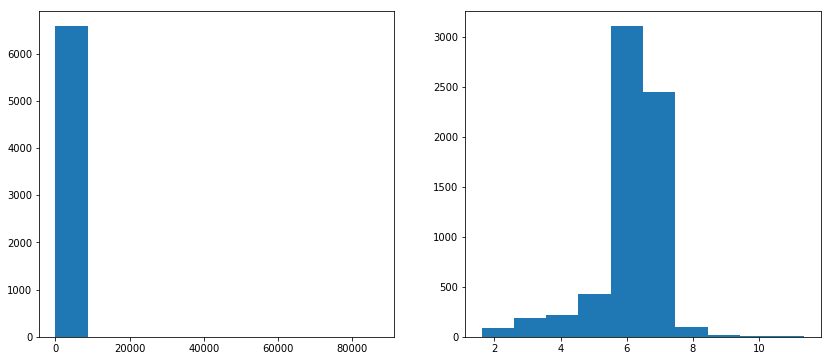

In [297]:
plt.figure(figsize = [14,6])
plt.subplot(121)
plt.hist(df['duration'])
plt.subplot(122)
plt.hist(df['duration'].apply(np.log))
plt.show()

In [298]:
# duration 변수가 지나치게 left-skewed라서 log 적용하였음.
df['duration'] = df['duration'].apply(np.log)

In [299]:
print(list(df.columns))

['start', 'prog', 'duration', '18?', 'US?', 'sex', 'age', 'trip_int', 'trip_dom', 'trip_risk', 'know_1', 'know_2', 'know_3', 'know_4', 'know_5', 'know_6', 'know_7', 'know_8', 'know_9', 'know_10', 'know_11', 'know_12', 'know_13', 'knowinf_1', 'knowinf_2', 'knowinf_3', 'knowinf_4', 'knowinf_5', 'knowinf_6', 'knowinf_7', 'knowinf_8', 'knowinf_9', 'knowinf_10', 'search', 'source_part', 'source_fam', 'source_fre', 'source_reli', 'source_doct', 'source_tv', 'source_radi', 'source_news', 'source_gov', 'source_soc', 'source_web', 'mainst_?', 'mainst_most', 'source_most', 'info_accu', 'info_upto', 'behav_1', 'behav_2', 'behav_3', 'behav_4', 'behav_5', 'behav_6', 'behav_7', 'behav_8', 'behav_9', 'behav_10', 'behav_11', 'behav_12', 'behav7_1', 'behav7_2', 'behav7_3', 'behav7_4', 'smoke', 'drink', 'sleep', 'trav_sev', 'trav_cruise', 'trav_plan_int', 'trav_plan_dom', 'percv_risk', '3mon_cases', 'percv_sev', 'belief_1', 'belief_2', 'belief_3', 'belief_4', 'belief_5', 'belief_6', 'belief_7', 'belief_

In [300]:
df['age18'] = df['18?']
del df['18?']
df['US'] = df['US?']
del df['US?']
df['mainst_'] = df['mainst_?']
del df['mainst_?']
df['vote'] = df['vote_?']
del df['vote_?']
df['three_mon_cases'] = df['3mon_cases']
del df['3mon_cases']
df['optimism'] = df['optimism ']
del df['optimism ']

# 2. EDA

In [301]:
numerical = [x for x, y in df.dtypes.items() if y != 'object']
categorical = list(set(df.columns) - set(numerical))

## Numerical 변수 Description

In [79]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
start,6602.0,174.605877,61.863902,17.000000,136.000000,180.000000,232.000000,261.000000
prog,6602.0,84.743865,29.152416,8.000000,100.000000,100.000000,100.000000,100.000000
duration,6602.0,6.167043,0.984300,1.609438,6.107023,6.390241,6.638568,11.373422
18?,6602.0,0.995910,0.063824,0.000000,1.000000,1.000000,1.000000,1.000000
US?,6602.0,0.998031,0.044334,0.000000,1.000000,1.000000,1.000000,1.000000
percv_risk,5326.0,5.414007,2.219339,0.000000,4.000000,5.000000,7.000000,10.000000
percv_sev,5339.0,6.008241,2.210522,0.000000,5.000000,6.000000,8.000000,10.000000
fedgov_resp,5167.0,3.336365,2.413161,0.000000,2.000000,3.000000,5.000000,10.000000
statgov_resp,5167.0,4.437198,2.369039,0.000000,3.000000,5.000000,6.000000,10.000000
know,6602.0,9.326871,3.232275,0.000000,9.000000,10.000000,11.000000,13.000000


## Categorical 변수 Description

In [80]:
pd.set_option('display.max_rows', 500)
df[categorical].describe().transpose().reset_index().sort_values(by=['index']).set_index('index')

,count,unique,top,freq
index,,,,
3mon_cases,5339,7,"Up to 1,000,000",2214
age,6391,7,50-59 years old,1758
anx_1,5044,4,Nearly every day,2069
anx_2,5044,4,Not at all,1554
anx_3,5044,4,Not at all,1835
anx_4,5044,4,Not at all,2221
attid_pol_1,5167,4,Strongly Agree,1857
attid_pol_2,5167,4,Disagree,1888
attid_pol_3,5167,4,Strongly Agree,3186


## Target Variable

y로 사용할 변수는 아래 두 개.  
  
- know: 지식 점수 (0-13) - NULL인 경우 0으로 처리했음에 유의  
- anx: 심리 불안

### know

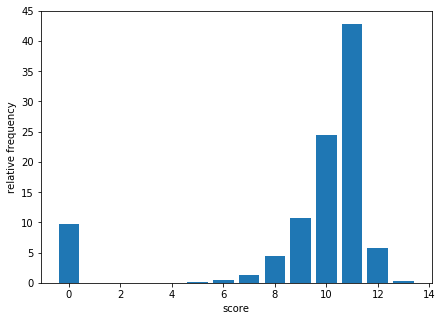

In [89]:
tmp = df.groupby(['know']).count()['start']
tmp = list(tmp / len(df) * 100)

plt.figure(figsize = [7,5])
plt.bar(list(range(0, 14)), tmp[0:1] + [0] * 3 + tmp[1:])
plt.xlabel('score')
plt.ylabel('relative frequency')
plt.show()

### search

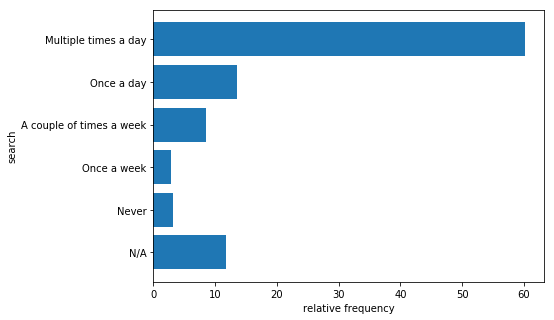

In [126]:
tmp = df[['search', 'start']].fillna('N/A').groupby(['search']).count()['start'].reset_index()
tmp['key'] = tmp['search'].apply(lambda x: {'N/A': 0, "Multiple times a day": 5, "Once a day": 4, "A couple of times a week": 3, "Once a week": 2, "Never": 1}[x])
tmp = tmp.sort_values(by = ['key'])
tmp['start'] = tmp['start'] / len(df) * 100

plt.figure(figsize = [7,5])
plt.barh(tmp['search'], tmp['start'])
# plt.xticks(list(range(len(tmp))), )
plt.ylabel('search')
plt.xlabel('relative frequency')
plt.show()

### anxiety

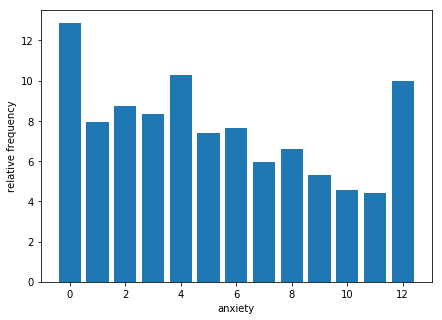

In [117]:
tmp = df.copy()
tmp['filter'] = 0
for i in range(1, 5):
    tmp['filter'] += tmp['anx_'+str(i)].fillna(-1).apply(lambda x: x if x == -1 else 0)
tmp = tmp[tmp['filter'] >= 0]
length = len(tmp)

tmp = tmp.groupby(['anx']).count()['start']
tmp = list(tmp / length * 100)

plt.figure(figsize = [7,5])
plt.bar(list(range(0, 13)), tmp)
plt.xlabel('anxiety')
plt.ylabel('relative frequency')
plt.show()

### 주요 변수 간 관계

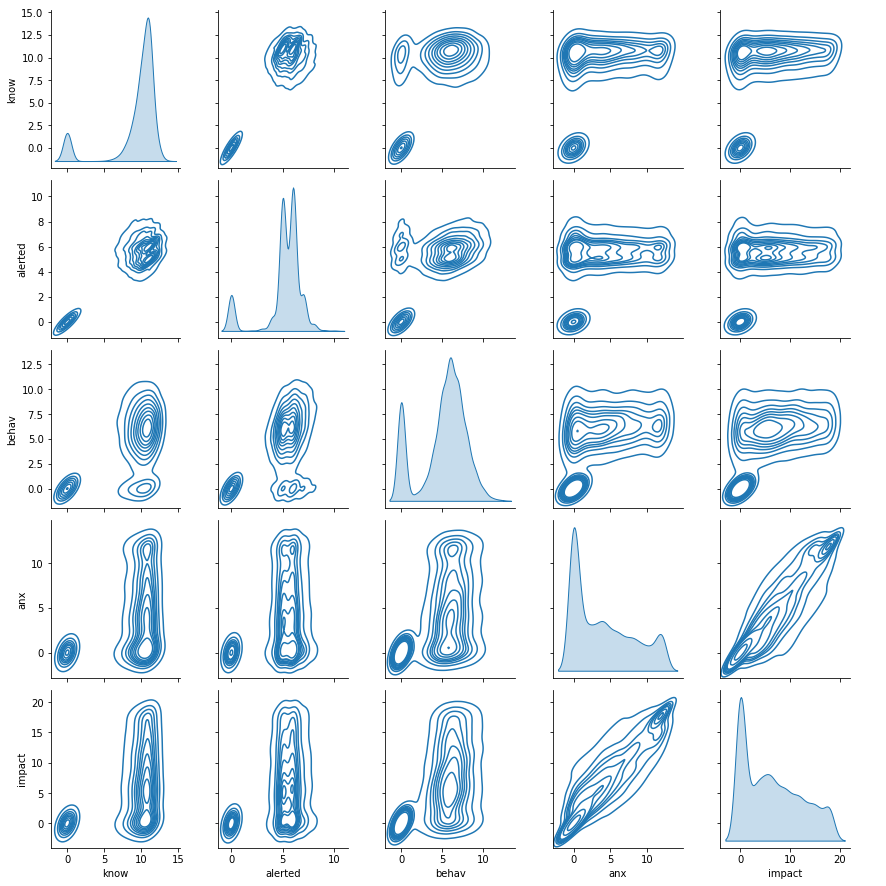

In [129]:
sns.pairplot(data = df[numerical[-5:]], kind='kde')

### 잠깐 전처리 추가

In [302]:
# numeric 중 na는 mean으로 처리
df['percv_risk'] = df['percv_risk'].fillna(np.mean(df['percv_risk']))
df['percv_sev'] = df['percv_sev'].fillna(np.mean(df['percv_sev']))
df['fedgov_resp'] = df['fedgov_resp'].fillna(np.mean(df['fedgov_resp']))
df['statgov_resp'] = df['statgov_resp'].fillna(np.mean(df['statgov_resp']))

In [303]:
# categorical 중 na는 'NULL'이라는 별도 카테고리로 처리
df = df.fillna('NULL')

In [304]:
for x in categorical:
    df[x] = df[x].apply(str)

# 3. Analysis (1): y = know

## Train-Test Split

In [392]:
tmp = df[[x for x in df.columns if x[:5] != 'know_']]
x_vars = [x for x in tmp.columns if x != 'know']

In [393]:
random.seed(1234)
te_idx = random.sample(range(len(tmp)), int(len(tmp) * 0.3))
tr_idx = list(set(range(len(tmp))) - set(te_idx))

In [394]:
train = tmp.iloc[tr_idx]
test = tmp.iloc[te_idx]

In [395]:
numerical1 = [x for x, y in train.dtypes.items() if y != 'object']
categorical1 = list(set(train.columns) - set(numerical1))

## OLS

In [396]:
result = sm.ols(formula = 'know~'+'+'.join(x_vars), data=train).fit()

In [397]:
result.summary().tables[0]

Dep. Variable:,know,R-squared:,0.917
Model:,OLS,Adj. R-squared:,0.911
Method:,Least Squares,F-statistic:,147.2
Date:,"Sat, 14 Nov 2020",Prob (F-statistic):,0.00
Time:,13:33:42,Log-Likelihood:,-6109.4
No. Observations:,4622,AIC:,1.286e+04
Df Residuals:,4299,BIC:,1.494e+04
Df Model:,322,,
Covariance Type:,nonrobust,,


In [398]:
# 유의한 변수들만 추린 것
tmp2 = result.summary().tables[1].as_html()
tmp2 = pd.read_html(tmp2, header=0, index_col=0)[0]
tmp2[tmp2['P>|t|'] < .05]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.4172,0.569,2.492,0.013,0.302,2.532
age[T.60-69 years old],-0.1611,0.069,-2.348,0.019,-0.296,-0.027
age[T.70-79 years old],-0.2716,0.091,-2.978,0.003,-0.450,-0.093
age[T.80+ years old],-0.4555,0.200,-2.281,0.023,-0.847,-0.064
trip_int[T.6-May],-2.2122,1.000,-2.213,0.027,-4.172,-0.252
trip_risk[T.High],0.1070,0.051,2.110,0.035,0.008,0.206
trip_risk[T.Moderate],0.1605,0.050,3.198,0.001,0.062,0.259
knowinf_1[T.NULL],-0.8270,0.032,-25.509,0.000,-0.891,-0.763
knowinf_2[T.NULL],-0.8270,0.032,-25.509,0.000,-0.891,-0.763
knowinf_2[T.True],-0.1802,0.052,-3.479,0.001,-0.282,-0.079


### MSE 

In [399]:
metrics.mean_squared_error(result.predict(test[x_vars]), test['know'])

0.9774527224476979

## LASSO

In [400]:
numerical1.remove('know')

cat_pipe = Pipeline(steps = [
    ("0", OneHotEncoder(handle_unknown = 'ignore'))
])

num_pipe = Pipeline(steps = [
    ("0", SimpleImputer(strategy='mean'))
])

prepro = ColumnTransformer(transformers = [
    ('cat', cat_pipe, categorical1),
    ('num', num_pipe, numerical1)
])

prepro.fit(train.drop(['know'], axis=1))
X = prepro.transform(train.drop(['know'], axis=1))
y = train['know']

In [401]:
grid = GridSearchCV(estimator=Lasso(), param_grid={'alpha': [x/10 for x in list(range(1, 10, 1))]}, scoring='neg_mean_squared_error')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [402]:
# Best alpha는 0.1
print(grid.best_estimator_)
# print(grid.best_score_)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


### MSE

In [403]:
X = prepro.transform(train.drop(['know'], axis=1))
y = train['know']
model = Lasso(alpha = 0.1)
model.fit(X, y)
X = prepro.transform(test.drop(['know'], axis=1))
y = test['know']
metrics.mean_squared_error(model.predict(X), y)

1.3030284864159223

Test Error 1.3으로 오히려 증가

## Ridge

In [404]:
cat_pipe = Pipeline(steps = [
    ("0", OneHotEncoder(handle_unknown = 'ignore'))
])

num_pipe = Pipeline(steps = [
    ("0", SimpleImputer(strategy='mean'))
])

prepro = ColumnTransformer(transformers = [
    ('cat', cat_pipe, categorical1),
    ('num', num_pipe, numerical1)
])

prepro.fit(train.drop(['know'], axis=1))
X = prepro.transform(train.drop(['know'], axis=1))
y = train['know']

In [405]:
grid = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [x/10 for x in list(range(1, 10, 1))]}, scoring='neg_mean_squared_error')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [406]:
# Best alpha는 0.2
print(grid.best_estimator_)
# print(grid.best_score_)

Ridge(alpha=0.2, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


### MSE

In [407]:
X = prepro.transform(train.drop(['know'], axis=1))
y = train['know']
model = Ridge(alpha = 0.2)
model.fit(X, y)
X = prepro.transform(test.drop(['know'], axis=1))
y = test['know']
metrics.mean_squared_error(model.predict(X), y)

0.9652466745390618

Test Error 0.96으로 OLS보다 나음.

## Decision Tree

In [408]:
cat_pipe = Pipeline(steps = [
    ("0", OneHotEncoder(handle_unknown = 'ignore'))
])

num_pipe = Pipeline(steps = [
    ("0", SimpleImputer(strategy='mean'))
])

prepro = ColumnTransformer(transformers = [
    ('cat', cat_pipe, categorical1),
    ('num', num_pipe, numerical1)
])

prepro.fit(train.drop(['know'], axis=1))
X = prepro.transform(train.drop(['know'], axis=1))
y = train['know']

In [410]:
grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [x for x in range(1, 11)]}, scoring='neg_mean_squared_error')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [411]:
# Best max_depth는 4
print(grid.best_estimator_)
# print(grid.best_score_)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')


### MSE

In [412]:
X = prepro.transform(train.drop(['know'], axis=1))
y = train['know']
model = DecisionTreeRegressor(max_depth = 4)
model.fit(X, y)
X = prepro.transform(test.drop(['know'], axis=1))
y = test['know']
metrics.mean_squared_error(model.predict(X), y)

1.0312464037432243

Test Error 1.03

# 4. Analysis (2): y = int(know > 10)

In [413]:
tmp = df.copy()
tmp['know_null'] = 0
for i in range(1, 14):
    tmp['know_null'] += tmp['know_'+str(i)].apply(lambda x: -1 if x == 'NULL' else 0)
tmp = tmp[tmp['know_null'] >= 0].drop(['know_null'], axis=1)

In [414]:
## Justification for know > 10: 10이 넘는 비중이 약 0.5
print(np.mean(tmp['know'] > 10))

0.5421140939597315


## Train-Test Split

In [415]:
tmp = tmp[[x for x in tmp.columns if x[:5] != 'know_']]
tmp['know'] = (tmp['know'] > 10).apply(int)
x_vars = [x for x in tmp.columns if x != 'know']

In [416]:
random.seed(1234)
te_idx = random.sample(range(len(tmp)), int(len(tmp) * 0.3))
tr_idx = list(set(range(len(tmp))) - set(te_idx))

In [417]:
train = tmp.iloc[tr_idx]
test = tmp.iloc[te_idx]

In [418]:
numerical1 = [x for x, y in train.dtypes.items() if y != 'object']
categorical1 = list(set(train.columns) - set(numerical1))
numerical1.remove('know')

## Logistic Regression with L1 or L2 Penalty (Lasso or Ridge Penalty)

In [419]:
cat_pipe = Pipeline(steps = [
    ("0", OneHotEncoder(handle_unknown = 'ignore'))
])

num_pipe = Pipeline(steps = [
    ("0", SimpleImputer(strategy='mean'))
])

prepro = ColumnTransformer(transformers = [
    ('cat', cat_pipe, categorical1),
    ('num', num_pipe, numerical1)
])

prepro.fit(train.drop(['know'], axis=1))
X = prepro.transform(train.drop(['know'], axis=1))
y = train['know']

In [420]:
grid = GridSearchCV(estimator=LogisticRegression(), param_grid={'C': [x/2 for x in range(1,7)], 'penalty': ['l1', 'l2']}, scoring='accuracy')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [421]:
grid.best_params_

{'C': 0.5, 'penalty': 'l1'}

### Accuracy

In [425]:
X = prepro.transform(train.drop(['know'], axis=1))
y = train['know']
model = LogisticRegression(C = .5, penalty = 'l1')
model.fit(X, y)
X = prepro.transform(test.drop(['know'], axis=1))
y = test['know']
metrics.accuracy_score(model.predict(X), y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6208053691275168

Accuracy 62%

## Decision Tree

In [486]:
cat_pipe = OneHotEncoder(handle_unknown = 'ignore')
cat_pipe.fit(train.drop(['know']+numerical1, axis=1))

X = cat_pipe.transform(train.drop(['know']+numerical1, axis=1))
X = np.append(X.toarray(), train[numerical1], axis=1)
y = train['know']

feature_names = list(cat_pipe.get_feature_names())

In [487]:
for i, x in enumerate(train.drop(['know']+numerical1, axis=1).columns):
    for j in range(len(feature_names)):
        text = feature_names[j].split('_')
        if text[0] == 'x'+str(i):
            feature_names[j] = x + '_' + '_'.join(text[1:])

In [488]:
feature_names += numerical1

In [489]:
grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={'max_depth': [x for x in range(2, 12, 1)], 'criterion': ['gini', 'entropy']}, scoring='accuracy')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [490]:
# Best max_depth는 2
print(grid.best_params_)
# print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 3}


### Accuracy

In [492]:
X = cat_pipe.transform(train.drop(['know']+numerical1, axis=1))
X = np.append(X.toarray(), train[numerical1], axis=1)
y = train['know']
model = DecisionTreeClassifier(max_depth = 3)
model.fit(X, y)
X = cat_pipe.transform(test.drop(['know']+numerical1, axis=1))
X = np.append(X.toarray(), test[numerical1], axis=1)
y = test['know']
metrics.accuracy_score(model.predict(X), y)

0.5805369127516778

Test Accuracy 58%

### Visualize

In [493]:
tree.export_graphviz(model,
                     out_file="tree.dot",
                     feature_names = feature_names,
                     class_names=["NO", "YES"],
                     filled = True)

In [494]:
!dot -Tpng tree.dot -o tree.png

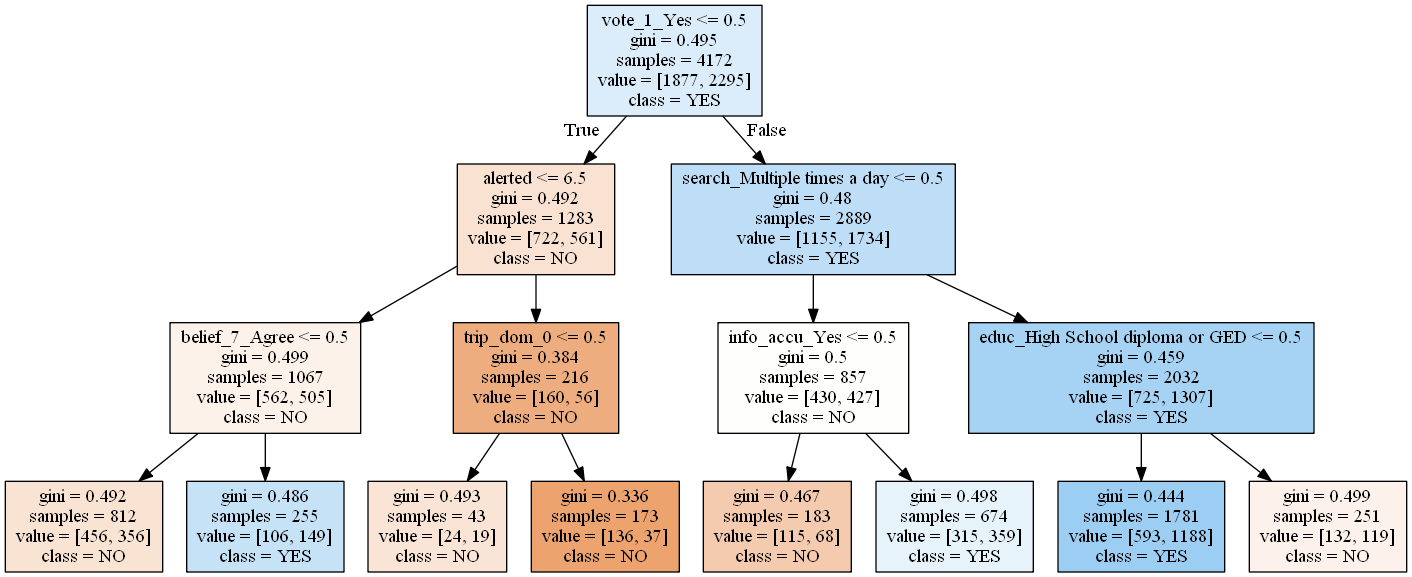

In [495]:
Image(filename='tree.png') 

# 5. Analysis (1): y = anxiety

## Train-Test Split

In [518]:
tmp = df.copy()
tmp['anx_null'] = 0
for i in range(1, 5):
    tmp['anx_null'] += tmp['anx_'+str(i)].apply(lambda x: -1 if x == 'NULL' else 0)
tmp = tmp[tmp['anx_null'] >= 0].drop(['anx_null'], axis=1)

In [519]:
tmp = tmp[[x for x in tmp.columns if x[:4] != 'anx_']]
x_vars = [x for x in tmp.columns if x != 'anx']

In [522]:
random.seed(1234)
te_idx = random.sample(range(len(tmp)), int(len(tmp) * 0.3))
tr_idx = list(set(range(len(tmp))) - set(te_idx))

In [523]:
train = tmp.iloc[tr_idx]
test = tmp.iloc[te_idx]

In [524]:
numerical1 = [x for x, y in train.dtypes.items() if y != 'object']
categorical1 = list(set(train.columns) - set(numerical1))

## OLS

In [525]:
result = sm.ols(formula = 'anx~'+'+'.join(x_vars), data=train).fit()

In [526]:
result.summary().tables[0]

Dep. Variable:,anx,R-squared:,0.721
Model:,OLS,Adj. R-squared:,0.694
Method:,Least Squares,F-statistic:,26.78
Date:,"Sat, 14 Nov 2020",Prob (F-statistic):,0.00
Time:,14:12:12,Log-Likelihood:,-7549.6
No. Observations:,3531,AIC:,1.572e+04
Df Residuals:,3219,BIC:,1.765e+04
Df Model:,311,,
Covariance Type:,nonrobust,,


In [527]:
# 유의한 변수들만 추린 것
tmp2 = result.summary().tables[1].as_html()
tmp2 = pd.read_html(tmp2, header=0, index_col=0)[0]
tmp2[tmp2['P>|t|'] < .05]

,coef,std err,t,P>|t|,[0.025,0.975]
sex[T.Male],-0.1892,0.092,-2.058,0.040,-0.369,-0.009
age[T.60-69 years old],-0.4813,0.187,-2.570,0.010,-0.849,-0.114
age[T.70-79 years old],-1.0088,0.253,-3.995,0.000,-1.504,-0.514
know_10[T.True],0.2873,0.143,2.009,0.045,0.007,0.568
source_most[T.Friends or Coworkers],2.0354,0.765,2.660,0.008,0.535,3.535
source_most[T.Spouse/Partner],0.5721,0.276,2.073,0.038,0.031,1.113
smoke[T.Little more],0.9507,0.328,2.902,0.004,0.308,1.593
sleep[T.Little more],-0.3221,0.136,-2.366,0.018,-0.589,-0.055
sleep[T.Not changed],-0.5016,0.131,-3.835,0.000,-0.758,-0.245
trav_plan_dom[T.Strongly Agree],0.3157,0.119,2.658,0.008,0.083,0.549


### MSE 

In [528]:
metrics.mean_squared_error(result.predict(test[x_vars]), test['anx'])

4.8196691868880235

## LASSO

In [529]:
numerical1.remove('anx')

cat_pipe = Pipeline(steps = [
    ("0", OneHotEncoder(handle_unknown = 'ignore'))
])

num_pipe = Pipeline(steps = [
    ("0", SimpleImputer(strategy='mean'))
])

prepro = ColumnTransformer(transformers = [
    ('cat', cat_pipe, categorical1),
    ('num', num_pipe, numerical1)
])

prepro.fit(train.drop(['anx'], axis=1))
X = prepro.transform(train.drop(['anx'], axis=1))
y = train['anx']

In [530]:
grid = GridSearchCV(estimator=Lasso(), param_grid={'alpha': [x/10 for x in list(range(1, 10, 1))]}, scoring='neg_mean_squared_error')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [534]:
# Best alpha는 0.1
print(grid.best_params_)
# print(grid.best_score_)

{'alpha': 0.1}


### MSE

In [535]:
X = prepro.transform(train.drop(['anx'], axis=1))
y = train['anx']
model = Lasso(alpha = 0.1)
model.fit(X, y)
X = prepro.transform(test.drop(['anx'], axis=1))
y = test['anx']
metrics.mean_squared_error(model.predict(X), y)

5.089231790293886

Test Error 5로 오히려 증가

## Ridge

In [536]:
cat_pipe = Pipeline(steps = [
    ("0", OneHotEncoder(handle_unknown = 'ignore'))
])

num_pipe = Pipeline(steps = [
    ("0", SimpleImputer(strategy='mean'))
])

prepro = ColumnTransformer(transformers = [
    ('cat', cat_pipe, categorical1),
    ('num', num_pipe, numerical1)
])

prepro.fit(train.drop(['anx'], axis=1))
X = prepro.transform(train.drop(['anx'], axis=1))
y = train['anx']

In [537]:
grid = GridSearchCV(estimator=Ridge(), param_grid={'alpha': [x/10 for x in list(range(1, 10, 1))]}, scoring='neg_mean_squared_error')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [538]:
# Best alpha는 0.2
print(grid.best_params_)
# print(grid.best_score_)

{'alpha': 0.9}


### MSE

In [539]:
X = prepro.transform(train.drop(['anx'], axis=1))
y = train['anx']
model = Ridge(alpha = 0.9)
model.fit(X, y)
X = prepro.transform(test.drop(['anx'], axis=1))
y = test['anx']
metrics.mean_squared_error(model.predict(X), y)

4.57312945446527

Test Error 4.57으로 OLS보다 나음.

## Decision Tree

In [540]:
cat_pipe = Pipeline(steps = [
    ("0", OneHotEncoder(handle_unknown = 'ignore'))
])

num_pipe = Pipeline(steps = [
    ("0", SimpleImputer(strategy='mean'))
])

prepro = ColumnTransformer(transformers = [
    ('cat', cat_pipe, categorical1),
    ('num', num_pipe, numerical1)
])

prepro.fit(train.drop(['anx'], axis=1))
X = prepro.transform(train.drop(['anx'], axis=1))
y = train['anx']

In [541]:
grid = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid={'max_depth': [x for x in range(1, 11)]}, scoring='neg_mean_squared_error')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [542]:
# Best max_depth는 4
print(grid.best_params_)
# print(grid.best_score_)

{'max_depth': 4}


### MSE

In [543]:
X = prepro.transform(train.drop(['anx'], axis=1))
y = train['anx']
model = DecisionTreeRegressor(max_depth = 4)
model.fit(X, y)
X = prepro.transform(test.drop(['anx'], axis=1))
y = test['anx']
metrics.mean_squared_error(model.predict(X), y)

5.344606252847569

Test Error 5.34

# 6. Analysis (2): y = int(anx >= 6)

In [545]:
tmp['anx'] = tmp['anx'].apply(lambda x: int(x>=6))

## Train-Test Split

In [547]:
x_vars = [x for x in tmp.columns if x != 'anx']

In [548]:
random.seed(1234)
te_idx = random.sample(range(len(tmp)), int(len(tmp) * 0.3))
tr_idx = list(set(range(len(tmp))) - set(te_idx))

In [549]:
train = tmp.iloc[tr_idx]
test = tmp.iloc[te_idx]

In [551]:
numerical1 = [x for x, y in train.dtypes.items() if y != 'object']
categorical1 = list(set(train.columns) - set(numerical1))
numerical1.remove('anx')

## Logistic Regression with L1 or L2 Penalty (Lasso or Ridge Penalty)

In [552]:
cat_pipe = Pipeline(steps = [
    ("0", OneHotEncoder(handle_unknown = 'ignore'))
])

num_pipe = Pipeline(steps = [
    ("0", SimpleImputer(strategy='mean'))
])

prepro = ColumnTransformer(transformers = [
    ('cat', cat_pipe, categorical1),
    ('num', num_pipe, numerical1)
])

prepro.fit(train.drop(['anx'], axis=1))
X = prepro.transform(train.drop(['anx'], axis=1))
y = train['anx']

In [553]:
grid = GridSearchCV(estimator=LogisticRegression(), param_grid={'C': [x/2 for x in range(1,7)], 'penalty': ['l1', 'l2']}, scoring='accuracy')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [554]:
grid.best_params_

{'C': 0.5, 'penalty': 'l1'}

### Accuracy

In [555]:
X = prepro.transform(train.drop(['anx'], axis=1))
y = train['anx']
model = LogisticRegression(C = .5, penalty = 'l1')
model.fit(X, y)
X = prepro.transform(test.drop(['anx'], axis=1))
y = test['anx']
metrics.accuracy_score(model.predict(X), y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8202247191011236

Accuracy 82%

## Decision Tree

In [556]:
cat_pipe = OneHotEncoder(handle_unknown = 'ignore')
cat_pipe.fit(train.drop(['anx']+numerical1, axis=1))

X = cat_pipe.transform(train.drop(['anx']+numerical1, axis=1))
X = np.append(X.toarray(), train[numerical1], axis=1)
y = train['anx']

feature_names = list(cat_pipe.get_feature_names())

In [557]:
for i, x in enumerate(train.drop(['anx']+numerical1, axis=1).columns):
    for j in range(len(feature_names)):
        text = feature_names[j].split('_')
        if text[0] == 'x'+str(i):
            feature_names[j] = x + '_' + '_'.join(text[1:])

In [558]:
feature_names += numerical1

In [567]:
grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={'max_depth': [x for x in range(2, 12, 1)], 'criterion': ['gini', 'entropy']}, scoring='accuracy')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [568]:
# Best max_depth는 2
print(grid.best_params_)
# print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 2}


### Accuracy

In [569]:
X = cat_pipe.transform(train.drop(['anx']+numerical1, axis=1))
X = np.append(X.toarray(), train[numerical1], axis=1)
y = train['anx']
model = DecisionTreeClassifier(max_depth = 2)
model.fit(X, y)
X = cat_pipe.transform(test.drop(['anx']+numerical1, axis=1))
X = np.append(X.toarray(), test[numerical1], axis=1)
y = test['anx']
metrics.accuracy_score(model.predict(X), y)

0.8056840713813616

Test Accuracy 81%

### Visualize

In [571]:
tree.export_graphviz(model,
                     out_file="tree.dot",
                     feature_names = feature_names,
                     class_names=["NO", "YES"],
                     filled = True)

In [572]:
!dot -Tpng tree.dot -o tree.png

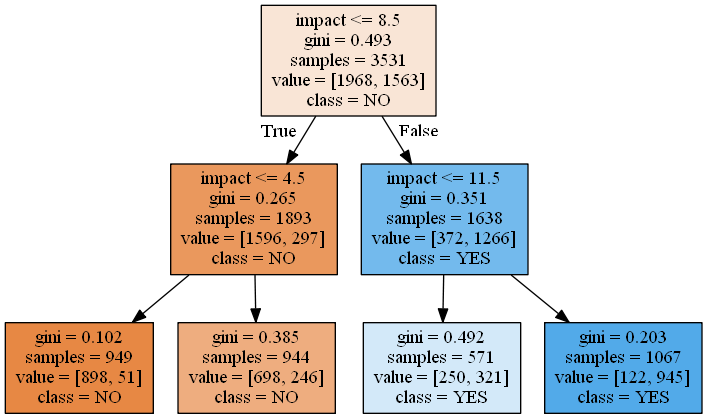

In [573]:
Image(filename='tree.png') 

## Decision Tree (w.o impact variables)

In [577]:
# numerical1.remove('impact')
cat_pipe = OneHotEncoder(handle_unknown = 'ignore')
cat_pipe.fit(train.drop(['anx']+numerical1+[x for x in train.columns if 'impact' in x], axis=1))

X = cat_pipe.transform(train.drop(['anx']+numerical1+[x for x in train.columns if 'impact' in x], axis=1))
X = np.append(X.toarray(), train[numerical1], axis=1)
y = train['anx']

feature_names = list(cat_pipe.get_feature_names())

In [578]:
for i, x in enumerate(train.drop(['anx']+numerical1+[x for x in train.columns if 'impact' in x], axis=1).columns):
    for j in range(len(feature_names)):
        text = feature_names[j].split('_')
        if text[0] == 'x'+str(i):
            feature_names[j] = x + '_' + '_'.join(text[1:])

In [579]:
feature_names += numerical1

In [580]:
grid = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid={'max_depth': [x for x in range(2, 12, 1)], 'criterion': ['gini', 'entropy']}, scoring='accuracy')
grid.fit(X, y)

C:\Users\myeon\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [581]:
# Best max_depth는 2
print(grid.best_params_)
# print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 5}


### Accuracy

In [582]:
X = cat_pipe.transform(train.drop(['anx']+numerical1+[x for x in train.columns if 'impact' in x], axis=1))
X = np.append(X.toarray(), train[numerical1], axis=1)
y = train['anx']
model = DecisionTreeClassifier(max_depth = 5)
model.fit(X, y)
X = cat_pipe.transform(test.drop(['anx']+numerical1+[x for x in train.columns if 'impact' in x], axis=1))
X = np.append(X.toarray(), test[numerical1], axis=1)
y = test['anx']
metrics.accuracy_score(model.predict(X), y)

0.643093192333113

Test Accuracy 64%

### Visualize

In [586]:
tree.export_graphviz(model,
                     out_file="tree_anx_wo_impact.dot",
                     feature_names = feature_names,
                     class_names=["NO", "YES"],
                     filled = True)

In [587]:
!dot -Tpng tree_anx_wo_impact.dot -o tree_anx_wo_impact.png

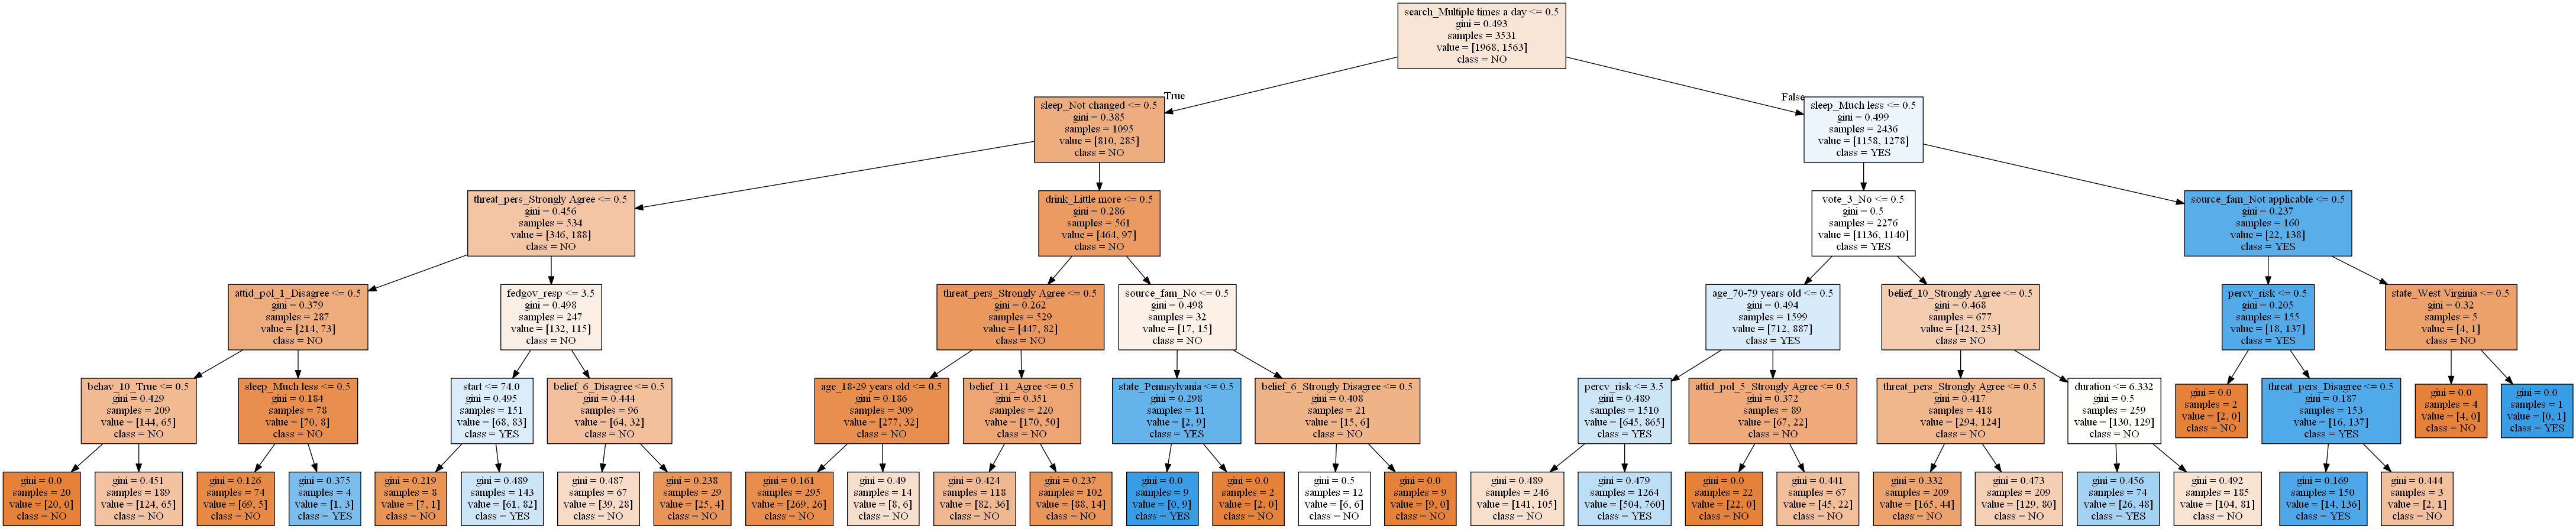

In [588]:
Image(filename='tree_anx_wo_impact.png') 

To-do's

y 뭐로 쓸지에 대해 고민해보기-  
제곱 변수 넣기-  
ordinal 변환 따로 시도해보기-  